In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [44]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Scale the labels
scale_factor = 1000.0
# Scale the training set's label.
train_df["median_house_value"] /= scale_factor
train_df = train_df.reindex(np.random.permutation(train_df.index))

# Scale the test set's label
test_df["median_house_value"] /= scale_factor
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
8973,-118.92,35.37,17.0,3589.0,701.0,1746.0,640.0,2.4919,75.7
3939,-117.96,33.94,31.0,2397.0,518.0,1407.0,476.0,2.6641,185.2
16214,-122.48,37.78,52.0,2666.0,515.0,1362.0,494.0,4.2180,393.8
9955,-119.75,34.45,26.0,3578.0,677.0,1504.0,618.0,4.1375,395.0
699,-117.05,32.97,17.0,9911.0,1436.0,4763.0,1414.0,5.5882,194.3


In [45]:
feature_cols = []
resolution_in_degrees = 0.4

# merepresentasikan kolom-kolom yang akan digunakan sebagai feature
lat_col = tf.feature_column.numeric_column("latitude")

# bikin np.array dari latitude terkecil sampai terbesar dengan resolusi / interval 1
lat_boundaries = list(np.arange(int(min(train_df["latitude"])), int(max(train_df["latitude"])), resolution_in_degrees))

# bikin tempat untuk mewadahi latitude dengan bucket / binning sekian
latitude = tf.feature_column.bucketized_column(lat_col, boundaries=lat_boundaries)

long_col = tf.feature_column.numeric_column("longitude")
long_boundaries = list(np.arange(int(min(train_df["longitude"])), int(max(train_df["longitude"])), resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(long_col, boundaries=long_boundaries)


# bikin crossed column antara lat & long
lat_x_long = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)

# jadikan crossed column tadi sebagai indicator column (One-Hot Encoding)
crossed_feature = tf.feature_column.indicator_column(lat_x_long)

feature_cols.append(crossed_feature)
cross_feature_layer = layers.DenseFeatures(feature_cols)

In [46]:
def create_model(_learning_rate, _feature_layer):
    _model = tf.keras.Sequential()
    _model.add(_feature_layer)
    _model.add(layers.Dense(units=1, input_shape=(1,)))
    _model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=_learning_rate),
        loss="mean_squared_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    return _model

def train_model(_model, _dataset, _epochs, _batch_size, _label_name, _validation_split):
    _features = {
        name:np.array(value) for name, value in _dataset.items() if name != _label_name
    }
    _labels = np.array(_dataset[_label_name])
    _history = _model.fit(
        x=_features,
        y=_labels,
        batch_size=_batch_size,
        epochs=_epochs,
        shuffle=True,
        validation_split=_validation_split,
        verbose=0,
    )
    _epochs_trained = _history.epoch
    _hist = pd.DataFrame(_history.history)
    _rmse = _hist["root_mean_squared_error"]

    return _epochs_trained, _rmse

def plot_loss(_epochs, _rmse):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")
    plt.plot(_epochs, _rmse, label="Loss")
    plt.legend()
    plt.ylim(_rmse.min()*0.95, _rmse.max()*1.05)
    plt.show()

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


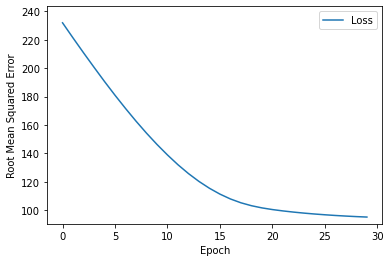


Evaluate against test dataset:
30/30 [==============================] - 0s 823us/step - loss: 8779.7266 - root_mean_squared_error: 93.7002


[8779.7265625, 93.7001953125]

In [47]:
learning_rate = 0.05
epochs = 30
batch_size = 100
validation_split = 0.2
label_name = "median_house_value"

model = create_model(learning_rate, cross_feature_layer)
epochs_trained, rmse = train_model(model, train_df, epochs, batch_size, label_name, validation_split)
plot_loss(epochs_trained, rmse)

print("\nEvaluate against test dataset:")
test_features = {
    name:np.array(value) for name, value in test_df.items() if name != label_name
}
test_labels = np.array(test_df[label_name])
model.evaluate(test_features, test_labels, batch_size=batch_size)